# Test et comparaisons de nos modèles

In [1]:
import time

t_debut = time.time()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

from tools import datasets

Importation de la liste des variables explicatives sélectionnées, des meilleurs paramètres et du seuil ajusté pour chaque modèle.

In [2]:
import json

# Régression logistique
with open('backups/RFECV_LR.json') as column_file:
    LR_COLUMNS = json.load(column_file)
    LR_COLUMNS_QUANT = LR_COLUMNS['columns_quant']
    LR_COLUMNS_CAT = LR_COLUMNS['columns_cat']
    LR_COLUMNS = LR_COLUMNS_QUANT + LR_COLUMNS_CAT

with open('backups/PARAMS_LR.json') as param_file:
    LR_PARAMS = json.load(param_file)

print(f'Variables explicatives régression logistique ({len(LR_COLUMNS)}) :')
display(LR_COLUMNS)

print(f'Meilleurs paramètres régression logistique ({len(LR_PARAMS)}) :')
display(LR_PARAMS)

# Forêts aléatoires
with open('backups/RFECV_Forest.json') as column_file:
    F_COLUMNS = json.load(column_file)
    F_COLUMNS_QUANT = F_COLUMNS['columns_quant']
    F_COLUMNS_CAT = F_COLUMNS['columns_cat']
    F_COLUMNS = F_COLUMNS_QUANT + F_COLUMNS_CAT

with open('backups/PARAMS_Forest.json') as param_file:
    F_PARAMS = json.load(param_file)

print(f'Variables explicatives forêts aléatoires ({len(F_COLUMNS)}) :')
display(F_COLUMNS)

print(f'Meilleurs paramètres forêts aléatoires ({len(F_PARAMS)}) :')
F_PARAMS['class_weight'] = {int(k): v for k,v in F_PARAMS['class_weight'].items()}
display(F_PARAMS)

# XGBoost
with open('backups/RFECV_XGBoost.json') as column_file:
    XG_COLUMNS = json.load(column_file)
    XG_COLUMNS_QUANT = XG_COLUMNS['columns_quant']
    XG_COLUMNS_CAT = XG_COLUMNS['columns_cat']
    XG_COLUMNS = XG_COLUMNS_QUANT + XG_COLUMNS_CAT

with open('backups/PARAMS_XGBoost.json') as param_file:
    XG_PARAMS = json.load(param_file)

print(f'Variables explicatives XGBoost ({len(XG_COLUMNS)}) :')
display(XG_COLUMNS)

print(f'Meilleurs paramètres XGBoost ({len(XG_PARAMS)}) :')
display(XG_PARAMS)

# Seuils ajustés
with open('backups/THRESHOLD.json') as threshold_file:
    SEUILS = json.load(threshold_file)

print("Seuils ajustés :")
display(SEUILS)

Variables explicatives régression logistique (11) :


['zonecostineuro',
 'nbdisplay_1hour',
 'display_size',
 'campaignctrlast24h',
 'nbdayssincelastclick',
 'display_env_app_ios',
 'is_interstitial_True',
 'device_type_Desktop',
 'campaignscenario_13',
 'target_env_2',
 'device_type_iPhone']

Meilleurs paramètres régression logistique (2) :


{'C': 52.98316906283702, 'class_weight': 'balanced'}

Variables explicatives forêts aléatoires (9) :


['display_size',
 'nbdayssincelastclick',
 'campaignctrlast24h',
 'nbdisplay_1hour',
 'dayssincelastvisitdouble',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'contextid',
 'zonecostineuro',
 'is_interstitial_True']

Meilleurs paramètres forêts aléatoires (7) :


{'n_estimators': 1500,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'class_weight': {0: 1, 1: 32},
 'bootstrap': True}

Variables explicatives XGBoost (8) :


['nbdayssincelastclick',
 'campaignctrlast24h',
 'nbdisplay_1hour',
 'contextid',
 'zonecostineuro',
 'is_interstitial_True',
 'device_type_iPad',
 'device_type_Desktop']

Meilleurs paramètres XGBoost (8) :


{'subsample': 0.6,
 'scale_pos_weight': 16.5,
 'n_estimators': 150,
 'min_child_weight': 1,
 'max_depth': 2,
 'learning_rate': 0.1,
 'gamma': 1.5,
 'colsample_bytree': 1.0}

Seuils ajustés :


{'LR': 0.4556640624999999,
 'Forest': 0.5997070312500004,
 'XGBoost': 0.46718749999999987}

## Régression logistique

In [3]:
df_train = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
df_test = pd.read_csv('data/df_test_prepro.csv').sample(frac=1)
datasets_df_train = datasets(df_train, columns_quant=LR_COLUMNS_QUANT, columns_cat=LR_COLUMNS_CAT, verbose=False)
datasets_df_test = datasets(df_test, columns_quant=LR_COLUMNS_QUANT, columns_cat=LR_COLUMNS_CAT, verbose=False)
X_train_LR = datasets_df_train['X_scaled']
y_train_LR = datasets_df_train['y']
X_test_LR = datasets_df_test['X_scaled']
y_test_LR = datasets_df_test['y']

In [4]:
%%time
clf_LR = LogisticRegression(**LR_PARAMS)
t = time.time()
clf_LR.fit(X_train_LR, y_train_LR)
train_time_LR = time.time() - t

CPU times: user 4.74 s, sys: 656 ms, total: 5.4 s
Wall time: 1.85 s


In [5]:
def final_predictor_LR(X):
    y_probas = clf_LR.predict_proba(X)[:, 1]
    return (y_probas >= SEUILS['LR']) * 1

Matrice de confusion

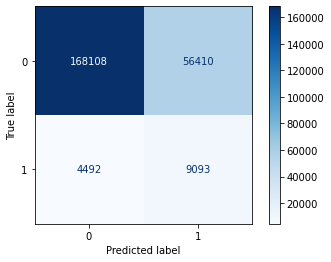

In [6]:
y_pred = final_predictor_LR(X_test_LR)
cm = confusion_matrix(y_test_LR, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

Courbe ROC

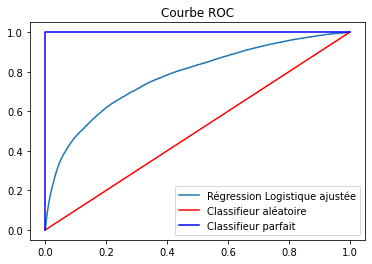

In [7]:
y_probas = clf_LR.predict_proba(X_test_LR)[:, 1]
fpr, tpr, _ = roc_curve(y_test_LR, y_probas)
plt.plot(fpr, tpr, label=f"Régression Logistique ajustée")
plt.plot([0, 1], [0, 1], "r-", label='Classifieur aléatoire')
plt.plot([0, 0, 1], [0, 1, 1], 'b-', label='Classifieur parfait')
plt.legend()
plt.title('Courbe ROC')
plt.show()

Métriques

In [8]:
t = time.time()
y_pred = final_predictor_LR(X_test_LR)
pred_time_LR = time.time() - t
recall, precision = recall_score(y_test_LR, y_pred), precision_score(y_test_LR, y_pred)

METRIQUES_LR = pd.DataFrame({"Nom": "Régression logistique",
    "Précicion": [precision],
    "Rappel": [recall],
    "Score F1": [(2 * precision * recall) / (precision + recall)],
    "Score F3": [(10 * precision * recall) / (9 * precision + recall)],
    "Score F5": [(26 * precision * recall) / (25 * precision + recall)],
    "Aire sous la courbe ROC": [roc_auc_score(y_test_LR, y_pred)],
    "Durée d'apprentissage": [train_time_LR],
    "Durée de prédiction": [pred_time_LR]})

METRIQUES_LR.style.hide_index()

Nom,Précicion,Rappel,Score F1,Score F3,Score F5,Aire sous la courbe ROC,Durée d'apprentissage,Durée de prédiction
Régression logistique,0.138818,0.669341,0.229946,0.484268,0.583564,0.709046,1.846967,0.008667


## Forêts aléatoires

In [9]:
df_train = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
df_test = pd.read_csv('data/df_test_prepro.csv').sample(frac=1)
datasets_df_train = datasets(df_train, columns_quant=F_COLUMNS_QUANT, columns_cat=F_COLUMNS_CAT, verbose=False)
datasets_df_test = datasets(df_test, columns_quant=F_COLUMNS_QUANT, columns_cat=F_COLUMNS_CAT, verbose=False)
X_train_F = datasets_df_train['X']
y_train_F = datasets_df_train['y']
X_test_F = datasets_df_test['X']
y_test_F = datasets_df_test['y']

In [10]:
%%time
clf_F = RandomForestClassifier(**F_PARAMS, n_jobs=-1)
t = time.time()
clf_F.fit(X_train_F, y_train_F)
train_time_F = time.time() - t

CPU times: user 1h 36min 38s, sys: 1min 1s, total: 1h 37min 39s
Wall time: 14min 20s


In [11]:
def final_predictor_F(X):
    y_probas = clf_F.predict_proba(X)[:, 1]
    return (y_probas >= SEUILS['Forest']) * 1

Matrice de confusion

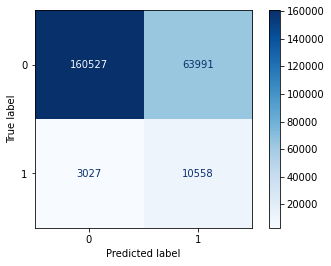

In [12]:
y_pred = final_predictor_F(X_test_F)
cm = confusion_matrix(y_test_F, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

Courbe ROC

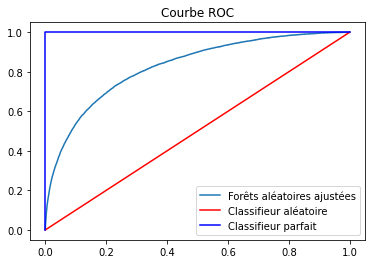

In [13]:
y_probas = clf_F.predict_proba(X_test_F)[:, 1]
fpr, tpr, _ = roc_curve(y_test_F, y_probas)
plt.plot(fpr, tpr, label=f"Forêts aléatoires ajustées")
plt.plot([0, 1], [0, 1], "r-", label='Classifieur aléatoire')
plt.plot([0, 0, 1], [0, 1, 1], 'b-', label='Classifieur parfait')
plt.legend()
plt.title('Courbe ROC')
plt.show()

Métriques

In [14]:
t = time.time()
y_pred = final_predictor_F(X_test_F)
pred_time_F = time.time() - t
recall, precision = recall_score(y_test_F, y_pred), precision_score(y_test_F, y_pred)

METRIQUES_F = pd.DataFrame({"Nom": "Forêts aléatoires",
    "Précicion": [precision],
    "Rappel": [recall],
    "Score F1": [(2 * precision * recall) / (precision + recall)],
    "Score F3": [(10 * precision * recall) / (9 * precision + recall)],
    "Score F5": [(26 * precision * recall) / (25 * precision + recall)],
    "Aire sous la courbe ROC": [roc_auc_score(y_test_F, y_pred)],
    "Durée d'apprentissage": [train_time_F],
    "Durée de prédiction": [pred_time_F]})

METRIQUES_F.style.hide_index()

Nom,Précicion,Rappel,Score F1,Score F3,Score F5,Aire sous la courbe ROC,Durée d'apprentissage,Durée de prédiction
Forêts aléatoires,0.141625,0.777181,0.239590,0.536446,0.662784,0.746083,860.428250,7.088519


## XGBoost

In [15]:
df_train = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
df_test = pd.read_csv('data/df_test_prepro.csv').sample(frac=1)
datasets_df_train = datasets(df_train, columns_quant=XG_COLUMNS_QUANT, columns_cat=XG_COLUMNS_CAT, verbose=False)
datasets_df_test = datasets(df_test, columns_quant=XG_COLUMNS_QUANT, columns_cat=XG_COLUMNS_CAT, verbose=False)
X_train_XG = datasets_df_train['X']
y_train_XG = datasets_df_train['y']
X_test_XG = datasets_df_test['X']
y_test_XG = datasets_df_test['y']

In [16]:
%%time
clf_XG = XGBClassifier(**XG_PARAMS, booster='gbtree', objective='binary:logistic', use_label_encoder=False, n_jobs=-1)
t = time.time()
clf_XG.fit(X_train_XG, y_train_XG)
train_time_XG = time.time() - t

[16:30:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 3min 17s, sys: 5.15 s, total: 3min 22s
Wall time: 28.6 s


In [17]:
def final_predictor_XG(X):
    y_probas = clf_XG.predict_proba(X)[:, 1]
    return (y_probas >= SEUILS['XGBoost']) * 1

Matrice de confusion

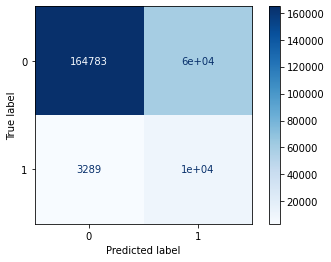

In [18]:
y_pred = final_predictor_XG(X_test_XG)
cm = confusion_matrix(y_test_XG, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

Courbe ROC

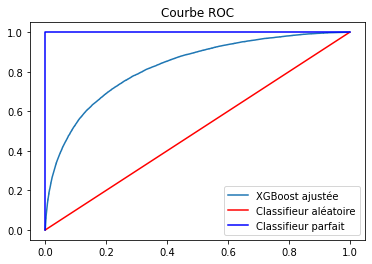

In [19]:
y_probas = clf_XG.predict_proba(X_test_XG)[:, 1]
fpr, tpr, _ = roc_curve(y_test_XG, y_probas)
plt.plot(fpr, tpr, label=f"XGBoost ajustée")
plt.plot([0, 1], [0, 1], "r-", label='Classifieur aléatoire')
plt.plot([0, 0, 1], [0, 1, 1], 'b-', label='Classifieur parfait')
plt.legend()
plt.title('Courbe ROC')
plt.show()

Métriques

In [20]:
t = time.time()
y_pred = final_predictor_XG(X_test_XG)
pred_time_XG = time.time() - t
recall, precision = recall_score(y_test_XG, y_pred), precision_score(y_test_XG, y_pred)

METRIQUES_XG = pd.DataFrame({"Nom": "XGBoost",
    "Précicion": [precision],
    "Rappel": [recall],
    "Score F1": [(2 * precision * recall) / (precision + recall)],
    "Score F3": [(10 * precision * recall) / (9 * precision + recall)],
    "Score F5": [(26 * precision * recall) / (25 * precision + recall)],
    "Aire sous la courbe ROC": [roc_auc_score(y_test_XG, y_pred)],
    "Durée d'apprentissage": [train_time_XG],
    "Durée de prédiction": [pred_time_XG]})

METRIQUES_XG.style.hide_index()

Nom,Précicion,Rappel,Score F1,Score F3,Score F5,Aire sous la courbe ROC,Durée d'apprentissage,Durée de prédiction
XGBoost,0.147021,0.757895,0.246269,0.535425,0.653465,0.745918,28.557747,0.076982


## Tableau récapitulatif

Modèles classés par F3.

In [25]:
RESULTATS = pd.concat([METRIQUES_LR, METRIQUES_F, METRIQUES_XG], ignore_index=True)
RESULTATS.sort_values("Score F3", ascending=False, inplace=True)
RESULTATS.style.hide_index()

Nom,Précicion,Rappel,Score F1,Score F3,Score F5,Aire sous la courbe ROC,Durée d'apprentissage,Durée de prédiction
Forêts aléatoires,0.141625,0.777181,0.239590,0.536446,0.662784,0.746083,860.428250,7.088519
XGBoost,0.147021,0.757895,0.246269,0.535425,0.653465,0.745918,28.557747,0.076982
Régression logistique,0.138818,0.669341,0.229946,0.484268,0.583564,0.709046,1.846967,0.008667


Considérant la durée de prédiction et le faible écart de score entre les deux meilleurs modèles en termes de F3, le modèle XGBoost est, parmi ces trois modèles, le plus adapté à notre problématique.

In [22]:
print(f"Durée totale d'exécution : {time.strftime('%H:%M:%S', time.gmtime(time.time() - t_debut))}")

Durée totale d'exécution : 00:16:20
